Importing the necessary packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

Constants

In [3]:
#constants used in the particle filter
'''
num_particles : total numbers of particles
dt : time step in seconds
total_time : Total simulation time in seconds
g : gravitational force of gravity in meters/seconds^2
'''


num_particles = 100000
dt = 0.1  
total_time = 5  
time_steps = int(total_time / dt) #Calculation of time steps

process_min_noise = -0.5
process_max_noise = 0.5 

measurement_min_noise = -2.0
measurement_max_noise = 2.0

g = 9.81 

Initiliastion

In [4]:


particles = np.zeros((num_particles, 8))  
# 8 dimension --> [x1, y1, vx1, vy1, x2, y2, vx2, vy2] where x1,y1,vx1 and vy1 are positions and velocities of ball 1 in x and y directions and x2, y2, vx2, vy2 are postions and velocities of ball 2 in x and y directions

weights = np.ones(num_particles) / num_particles

# Launch parameters for the two balls
launch_position_ball1 = [0, 0]  # positions of ball 1 in x and y directions
random_val = random.randint(0,10)
launch_position_ball1 = [pos + random_val for pos in launch_position_ball1] #adding randomness since starting position can't be fixed
launch_speed_ball1 = 45  
launch_angle_ball1 = random.randint(30,60)  

launch_position_ball2 = [0, 10]  # positions of ball 2 in x and y directions
random_val = random.randint(0,10)
launch_position_ball2 = [pos + random_val for pos in launch_position_ball2] #adding randomness since starting position can't be fixed
launch_speed_ball2 = 20  
launch_angle_ball2 = random.randint(30,60)  

# Convert launch angles of balls from degrees to radians
launch_angle_rad_ball1 = np.radians(launch_angle_ball1)
launch_angle_rad_ball2 = np.radians(launch_angle_ball2)


'''
Initial state for the two balls based on launch parameters.
Intial state:[x,y,vx0,vy0] where x and y positions in x and y directions and vx0 and vy0 are accelerations in x and y directions
'''
initial_state_ball1 = [
   launch_position_ball1[0],
   launch_position_ball1[1],
    launch_speed_ball1 * np.cos(launch_angle_rad_ball1),
    launch_speed_ball1 * np.sin(launch_angle_rad_ball1)
]
initial_state_ball2 = [
   launch_position_ball2[0],
   launch_position_ball2[1],
   launch_speed_ball2 * np.cos(launch_angle_rad_ball2),
   launch_speed_ball2 * np.sin(launch_angle_rad_ball2)
]


# Initializing the particles around the initial state with added noise(i.e process_noise_std)
particles[:, 0:4] = initial_state_ball1 + np.random.uniform(process_min_noise,process_max_noise, size = (num_particles, 4)) #particles[:, 0:4] considers the first 4 column values(i.e values of ball 1)
particles[:, 4:8] = initial_state_ball2 + np.random.uniform(process_min_noise,process_max_noise, size = (num_particles, 4)) #particles[:, 4:8] considers the rest 4 column values (i.e values of ball 2)



Trajectory simulation

In [5]:


# Initialize true positions of balls
true_positions_ball1 = np.zeros((time_steps, 2))
true_positions_ball2 = np.zeros((time_steps, 2))
true_positions_ball1[0] = initial_state_ball1[:2]
true_positions_ball2[0] = initial_state_ball2[:2]

# Initialize true velocities for the balls
true_velocities_ball1 = np.zeros((time_steps, 2))
true_velocities_ball2 = np.zeros((time_steps, 2))
true_velocities_ball1[0] = initial_state_ball1[2:4]
true_velocities_ball2[0] = initial_state_ball2[2:4]

# Generate noisy observations
observed_positions = np.zeros((time_steps, 2, 2))  # [time, ball, coordinates]
#print(time_steps)
for t in range(1, time_steps):

   # Calculating the true positions and velocities using projectile motion equations.
   true_positions_ball1[t, 0] = true_positions_ball1[t-1, 0] + true_velocities_ball1[t-1, 0] * dt
   true_positions_ball1[t, 1] = true_positions_ball1[t-1, 1] + true_velocities_ball1[t-1, 1] * dt - 0.5 * g * dt**2
   true_velocities_ball1[t, 0] = true_velocities_ball1[t-1, 0]
   true_velocities_ball1[t, 1] = true_velocities_ball1[t-1, 1] - g * dt
   
   true_positions_ball2[t, 0] = true_positions_ball2[t-1, 0] + true_velocities_ball2[t-1, 0] * dt
   true_positions_ball2[t, 1] = true_positions_ball2[t-1, 1] + true_velocities_ball2[t-1, 1] * dt - 0.5 * g * dt**2
   true_velocities_ball2[t, 0] = true_velocities_ball2[t-1, 0]
   true_velocities_ball2[t, 1] = true_velocities_ball2[t-1, 1] - g * dt

# dropouts ( between t=6 and t=15)
for t in range(time_steps):
   if(6<t<20):
      observed_positions[t, 0] = [np.nan, np.nan]
      observed_positions[t, 1] = [np.nan, np.nan]
   else:    
      observed_positions[t, 0] = true_positions_ball1[t] + np.random.uniform(measurement_min_noise,measurement_max_noise, size = true_positions_ball1[t].shape)
      observed_positions[t, 1] = true_positions_ball2[t] + np.random.uniform(measurement_min_noise,measurement_max_noise, size = true_positions_ball1[t].shape)


The 3 functions of particle filter : prediction, updation and resampling

In [6]:
'''Prediction function:
Input values 
particles: a 2D array with intialised values for [x1,y1,vx1,vy1,x2,y2,vx2,vy2] of ball 1 and 2
dt : time difference
process_noise_std : a process noise std 

It updates position of balls based on velocity and add process noise 
'''

def prediction(particles, dt):
    # Update position based on velocity and add process noise
    particles[:, 0] += particles[:, 2] * dt + np.random.uniform(process_min_noise, process_max_noise)  # calculating the x1
    particles[:, 1] += particles[:, 3] * dt - 0.5 * g * dt**2 + np.random.uniform(process_min_noise, process_max_noise)  # calculating the y1
    particles[:, 2] += np.random.uniform(process_min_noise, process_max_noise)  # calculating the vx1
    particles[:, 3] += -g * dt + np.random.uniform(process_min_noise, process_max_noise)  # calculating the vy1
    
    particles[:, 4] += particles[:, 6] * dt + np.random.uniform(process_min_noise, process_max_noise)  #calculating the x2
    particles[:, 5] += particles[:, 7] * dt - 0.5 * g * dt**2 + np.random.uniform(process_min_noise, process_max_noise)  # calculating they2
    particles[:, 6] += np.random.uniform(process_min_noise, process_max_noise)  # calculating the vx2
    particles[:, 7] += -g * dt + np.random.uniform(process_min_noise, process_max_noise) # calculating the vy2


In [7]:
'''Update function
Arguments:
particles : a 2D array of calculated values for [x1,y1,vx1,vy1,x2,y2,vx2,vy2] of ball 1 and 2 from prediction function
weights : weights values
measurments : the observed positions of balls
measurement_noise_std : a measurement noise std value

'''

# Update function with handling for observation dropouts
def update(particles, weights, measurements, measurement_noise_std):
    for i in range(2):  # Iterate over two balls
        if not np.isnan(measurements[i, 0]):
            distance = np.linalg.norm(particles[:, 4*i:4*i+2] - measurements[i], axis=1)
            weights *= np.exp(-0.5 * (distance / measurement_noise_std)**2)
        else:
            weights[:] = 1.0 / len(weights)  # Uniform weights if observation is NaN
    
    weights += 1.e-300  # Avoid division by zero
    weights /= np.sum(weights)  # Normalize weights

    return weights


In [8]:
'''Resampling function

Arguments:
particles :  a 2D array of calculated values for [x1,y1,vx1,vy1,x2,y2,vx2,vy2] of ball 1 and 2 from prediction function
weights : The weights caluclated from updation function
'''
def resampling(particles, weights):
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    particles = particles[indices]
    weights = weights[indices]
    weights /= np.sum(weights)  # Normalize weights
    return particles, weights


Running the particle filter.

In [9]:



#intialising the estimated positions for balls
estimated_positions_ball1 = np.zeros((time_steps, 2))
estimated_positions_ball2 = np.zeros((time_steps, 2))

estimated_velocities_ball1 = np.zeros((time_steps,2))
estimated_velocities_ball2 = np.zeros((time_steps,2))

particle_history = []
for t in range(time_steps):
    if t > 0:
        prediction(particles, dt)
    
    
    measurement_noise = np.random. uniform(measurement_min_noise, measurement_max_noise)
    weights = update(particles, weights, observed_positions[t], measurement_noise)
    particles, weights = resampling(particles, weights)
    
    particle_history.append(particles.copy())
    # Estimating the position as the weighted mean of the particles
    estimated_positions_ball1[t] = np.average(particles[:, 0:2], weights=weights, axis=0)
    estimated_positions_ball2[t] = np.average(particles[:, 4:6], weights=weights, axis=0)
    
    # Estimating the velocity as the weighted mean of the particle's velocities
    estimated_velocities_ball1[t] = np.average(particles[:, 2:4], weights=weights, axis=0)
    estimated_velocities_ball2[t] = np.average(particles[:, 6:8], weights=weights, axis=0)

particles = np.array(particle_history)




Uncertainty

In [10]:
print('Estimated positions and True positions uncertainty : Ball 1')
differences = np.array(estimated_positions_ball1) - np.array(true_positions_ball1)

mean_difference = np.mean(differences)
std_deviation = np.std(differences)


print(f"Mean: {mean_difference}")
print(f"Standard Deviation (Uncertainty): {std_deviation}")


print('Estimated positions and True positions uncertainty : Ball 2')
differences = np.array(estimated_positions_ball2) - np.array(true_positions_ball2)

mean_difference = np.mean(differences)
std_deviation = np.std(differences)


print(f"Mean: {mean_difference}")
print(f"Standard Deviation (Uncertainty): {std_deviation}")

Estimated positions and True positions uncertainty : Ball 1
Mean: 0.03747370818924314
Standard Deviation (Uncertainty): 0.8324665985985649
Estimated positions and True positions uncertainty : Ball 2
Mean: 0.6435677980529371
Standard Deviation (Uncertainty): 1.3328408604543645


In [11]:
# Calculate RMSE
rmse_ball1 = np.sqrt(np.mean((true_positions_ball1 - estimated_positions_ball1) ** 2))
rmse_ball2 = np.sqrt(np.mean((true_positions_ball2 - estimated_positions_ball2) ** 2))

# Display RMSE
print(f"RMSE Ball 1: {rmse_ball1}")
print(f"RMSE Ball 2: {rmse_ball2}")

RMSE Ball 1: 0.8333096162817976
RMSE Ball 2: 1.4800825213438056


Plotting the results

C:\Users\anagha\AppData\Local\Temp\ipykernel_13296\1419714713.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(observed_positions[:, 0, 0], observed_positions[:, 0, 1], 'x', label='Observed Position Ball 1', linestyle='none', marker='x')
C:\Users\anagha\AppData\Local\Temp\ipykernel_13296\1419714713.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(observed_positions[:,1,0], observed_positions[:, 1, 1], 'x', label='Observed Position Ball 2',linestyle='none', marker='x')


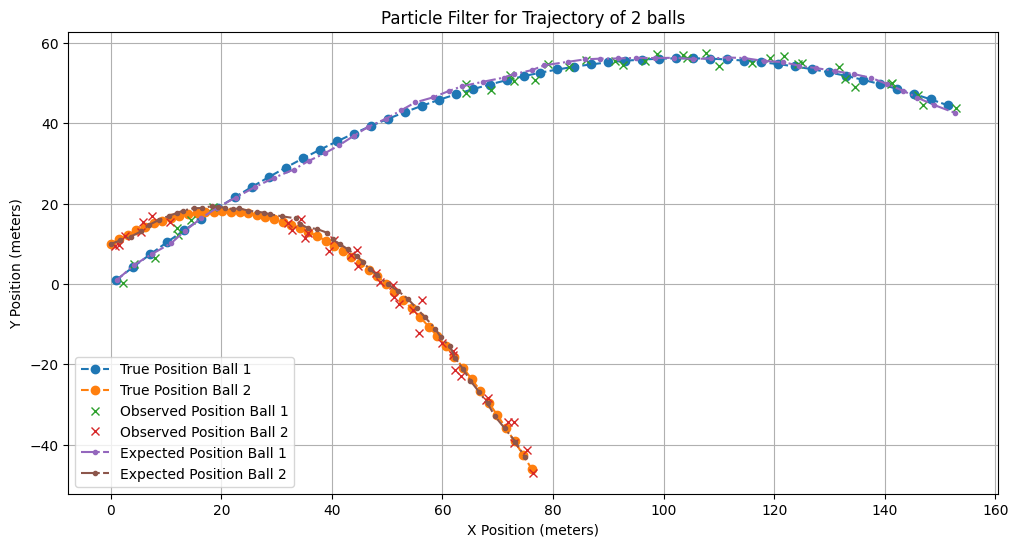

In [12]:
# Plot the results of true positions of ball1 and ball2, observed positions of ball 1.
plt.figure(figsize=(12, 6))
plt.plot(true_positions_ball1[:, 0], true_positions_ball1[:, 1], label='True Position Ball 1', linestyle='--',marker='o')
plt.plot(true_positions_ball2[:, 0], true_positions_ball2[:, 1], label='True Position Ball 2', linestyle='--',marker='o')
plt.plot(observed_positions[:, 0, 0], observed_positions[:, 0, 1], 'x', label='Observed Position Ball 1', linestyle='none', marker='x')
plt.plot(observed_positions[:,1,0], observed_positions[:, 1, 1], 'x', label='Observed Position Ball 2',linestyle='none', marker='x')
plt.plot(estimated_positions_ball1[:, 0], estimated_positions_ball1[:, 1], label='Expected Position Ball 1', linestyle='-.',marker='.')
plt.plot(estimated_positions_ball2[:, 0], estimated_positions_ball2[:, 1], label='Expected Position Ball 2', linestyle='-.',marker='.')
plt.legend()
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.title('Particle Filter for Trajectory of 2 balls')
plt.grid(True)
plt.show()

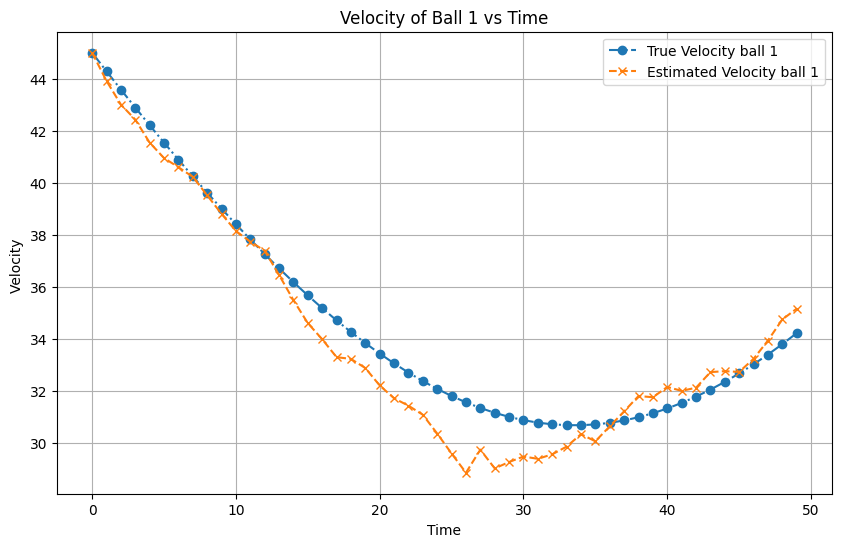

In [ ]:
# Calculate velocity (v_xy) for true and estimated velocities
true_velocity_magnitude_ball1 = np.sqrt(true_velocities_ball1[:, 0]**2 + true_velocities_ball1[:, 1]**2)
estimated_velocity_magnitude_ball1 = np.sqrt(estimated_velocities_ball1[:, 0]**2 + estimated_velocities_ball1[:, 1]**2)

plt.figure(figsize=(10, 6))

# Velocity magnitude plots
plt.plot(range(len(true_velocity_magnitude_ball1)), true_velocity_magnitude_ball1, label='True Velocity ball 1', linestyle='-.', marker='o')
plt.plot(range(len(estimated_velocity_magnitude_ball1)), estimated_velocity_magnitude_ball1, label='Estimated Velocity ball 1', linestyle='--', marker='x')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity ')
plt.title('Velocity of Ball 1 vs Time')
plt.grid(True)
plt.show()

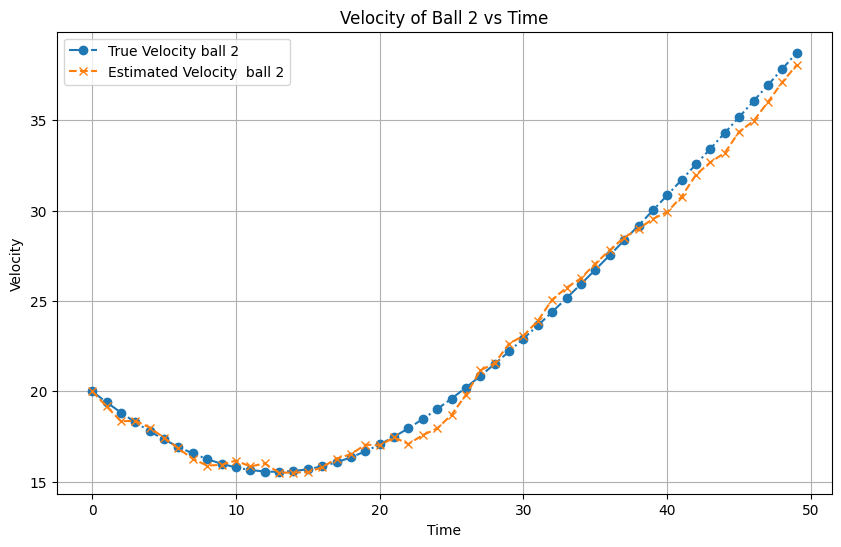

In [14]:
# Calculate velocity (v_xy) for true and estimated velocities
true_velocity_magnitude_ball2 = np.sqrt(true_velocities_ball2[:, 0]**2 + true_velocities_ball2[:, 1]**2)
estimated_velocity_magnitude_ball2 = np.sqrt(estimated_velocities_ball2[:, 0]**2 + estimated_velocities_ball2[:, 1]**2)

plt.figure(figsize=(10, 6))

# Velocity magnitude plots
plt.plot(range(len(true_velocity_magnitude_ball2)), true_velocity_magnitude_ball2, label='True Velocity ball 2', linestyle='-.', marker='o')
plt.plot(range(len(estimated_velocity_magnitude_ball2)), estimated_velocity_magnitude_ball2, label='Estimated Velocity  ball 2', linestyle='--', marker='x')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity of Ball 2 vs Time')
plt.grid(True)
plt.show()